# Reinforcement Learning Testbed for OpenAI Gym Problems

## Introduction

This IPython notebook attempts to define a set of classes and routines with the purpose of providing a **common protocol for the development of RL algorithms** running on top of [OpenAI gym API](https://gym.openai.com/).

Our aim here is to ease the burden of implementing the necessary boilerplate code to cope with the interface of a problem environment, as well as to offer a structured approach to extend basic RL methods and techniques.

### Imports

First things first, let's import everyting we need for this notebook.

In [1]:
import gym
from gym import spaces

import abc
import numpy as np
import matplotlib.pyplot as plt

import utils

%matplotlib inline

## OpenAI gym interface and environments

OpenAI gym API provides the RL practicionner with a number of interesting sequential decision-making problems ranging from simple problems to ATARI games and complex high-dimensional control problems.

The documentation of all provided environments are freely available at [https://gym.openai.com/envs/](https://gym.openai.com/envs/).

### Random Walk

In this particular notebook, we're gonna study a very simple problem encoded as a gym domain, e.g., the *Random
Walk*.

In [2]:
class RandomWalk():

    def __init__(self, n):
        self.n = n
        self.action_space = gym.spaces.discrete.Discrete(2)
        self.observation_space = gym.spaces.discrete.Discrete(n)
        self.reward_range = (0.0, 1.0)

    def reset(self):
        self.s = self.n // 2
        return self.s

    def step(self, a):
        if a == 0:   # left
            self.s -= 1
        elif a == 1: # right
            self.s += 1
        else:
            raise ValueError("action should be 0 or 1")

        r = 0.0
        if self.s == self.n - 1:
            r = 1.0

        done = False
        if self.s in [0, self.n - 1]:
            done = True

        info = {}

        return (self.s, r, done, info)

    def render(self):
        for s in range(self.n):
            if s == 0:
                pos = '0'
            elif s == self.n - 1:
                pos = '1'
            else:
                pos = chr(ord('A') + (s - 1))
            if s == self.s:
                print('|{}|'.format(pos), end='')
            else:
                print(' {} '.format(pos), end='')
            if s != self.n - 1:
                print(' -- ', end='')
        print()


Before diving into defining our testbed, let's first check out the state and action spaces, and reward limits of this environment.

In [3]:
env = RandomWalk(7)

print('State space:\t',  env.observation_space)
print('Action space:\t', env.action_space)
print('Reward:\t\t',     env.reward_range)

State space:	 Discrete(7)
Action space:	 Discrete(2)
Reward:		 (0.0, 1.0)


As expected from the MDP's definition of this particular problem, we indeed got a total of 7 possible states, 2 possible actions and a limited reward range.

The start state can be visualized this way:

In [4]:
s0 = env.reset()
print('>> Start state =', s0)
env.render()

>> Start state = 3
 0  --  A  --  B  -- |C| --  D  --  E  --  1 


## RL agent interacting with the environment

Let's recall the overall goal of solving an RL problem: to derive an optimal/rational/more-or-less-intelligent agent that, well, ... acts in the environment!

So, given this goal, it should pretty clear that need a way to define mechanisms for implementing:
1. the behavior of our agent (i.e., *policy*); and
2. its interactions with the environment (i.e, *trajectory sampling*).

### Policy: selecting actions

As a starting point, let's first consider a very simple behavior for our agent: to act completely at random in all states.

Although this can be thought as a very naïve approach, it is actually a rather important behavior to define in our framework, since it is a pretty standard baseline for performance measurement in RL.

So, let's develop a generic way to randomly select actions given an environment's action space. We call this mechanism the **agent's policy**.

Formally, this action selection mechanism can be represented by a **stochastic policy**.

Remember that a deterministic policy is defined by a function mapping states to actions (i.e., $\pi : \mathcal{S} \rightarrow \mathcal{A}$), whereas a stochastic policy is given by a **probability distribution over the set of actions** (i.e., $\pi : \mathcal{S} \times \mathcal{A} \rightarrow [0, 1]$).

In other words, for any stochastic policy $\pi(a|s)$ it holds the following conditions:
- $\sum_{a \in \mathcal{A}} \pi(a|s) = 1$, $\forall s \in \mathcal{S}$; and 
- an action $a$ is applicable in a state $s$ iff $\pi(a|s) > 0$.

In particular for a random policy, it holds that:
$$
\pi(a|s) = \frac{1}{|\mathcal{A}|}, \forall a \in \mathcal{A}, \forall s \in \mathcal{S}
$$
where $|\mathcal{A}|$ denotes the size of the action space.


In [5]:
class Policy(metaclass=abc.ABCMeta):
    
    def __init__(self, env):
        self.env = env
    
    @abc.abstractmethod
    def __call__(self, s):
        ''' Return action for state s. '''
        pass

In [6]:
class RandomPolicy(Policy):
    
    def __init__(self, env):
        super().__init__(env)
        
    def __call__(self, s):
        ''' Return a random action regardless of state s. '''
        return self.env.action_space.sample()

Let's check our random policy by selection a good deal of actions. 

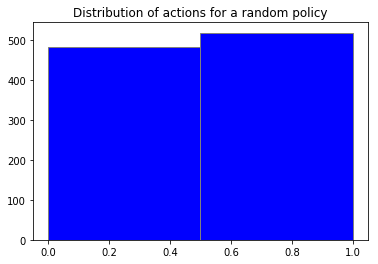

In [7]:
policy = RandomPolicy(env)

s0 = env.reset()

random_actions = []
for _ in range(1000):
    s = env.observation_space.sample()
    a = policy(s)
    random_actions.append(a)

action_space_size = env.action_space.n
utils.plot_action_distribution(random_actions, action_space_size)

### Sampling trajectories and episodes

Perphaps one of the core ideas in any RL framework is the concept of *trajectory sampling*. By trajectory, we simply mean a sequence of state-action-reward data points of the form $(s_t, a_{t+1}, r_{t+1}), t=0, 1, ...$, obtained by sampling stochastic transitions from a start state following a given policy.

In [8]:
def episode(env, policy, start=None):
    '''
    Generator for an episode.
    Yields a SARSA sample (s, a, r, s', a') at each step.
    If start is given, fix the start state and action.
    Otherwise, reset the environment and choose initial action
    from given policy.
    '''
    if start is None:
        s = env.reset()
        a = policy(s)
    else:
        s, a = start

    done = False
    while not done:        
        s_prime, r, done, info = env.step(a)
        a_prime = policy(s_prime)
        yield (s, a, r, s_prime, a_prime)
        s = s_prime
        a = a_prime

In [9]:
print('>> Trajectory:')
for i, (s, a, r, s_prime, a_prime) in enumerate(episode(env, policy)):
    print('sample #{:2}: s={:2}, a={}, r={:.1f}, s\'={:2}, a\'={}'.format(i, s, a, r, s_prime, a_prime), end='  ')
    env.render()

>> Trajectory:
sample # 0: s= 3, a=1, r=0.0, s'= 4, a'=1   0  --  A  --  B  --  C  -- |D| --  E  --  1 
sample # 1: s= 4, a=1, r=0.0, s'= 5, a'=0   0  --  A  --  B  --  C  --  D  -- |E| --  1 
sample # 2: s= 5, a=0, r=0.0, s'= 4, a'=1   0  --  A  --  B  --  C  -- |D| --  E  --  1 
sample # 3: s= 4, a=1, r=0.0, s'= 5, a'=0   0  --  A  --  B  --  C  --  D  -- |E| --  1 
sample # 4: s= 5, a=0, r=0.0, s'= 4, a'=1   0  --  A  --  B  --  C  -- |D| --  E  --  1 
sample # 5: s= 4, a=1, r=0.0, s'= 5, a'=0   0  --  A  --  B  --  C  --  D  -- |E| --  1 
sample # 6: s= 5, a=0, r=0.0, s'= 4, a'=1   0  --  A  --  B  --  C  -- |D| --  E  --  1 
sample # 7: s= 4, a=1, r=0.0, s'= 5, a'=0   0  --  A  --  B  --  C  --  D  -- |E| --  1 
sample # 8: s= 5, a=0, r=0.0, s'= 4, a'=0   0  --  A  --  B  --  C  -- |D| --  E  --  1 
sample # 9: s= 4, a=0, r=0.0, s'= 3, a'=1   0  --  A  --  B  -- |C| --  D  --  E  --  1 
sample #10: s= 3, a=1, r=0.0, s'= 4, a'=1   0  --  A  --  B  --  C  -- |D| --  E  --  1 
sample

## Learning process

In RL we are typically concerned with 2 competing processes: *prediction* and *control*. These are typically interleaved processes that compete in the sense of a *Generalized Policy Iteration* (GPI) framework.

In this notebook, we're gonna study only the **prediction** problem. Also, we shall present a general protocol that provides a common interface for the implementation of all prediction algorithms.

### Prediction: evaluating policies

Before we can start learning good policies, we need a way to measure the quality of a given policy. This is known  as the **prediction problem** in RL.

Our goal here will be to estimate the expected total return received by following policy $\pi$ from a start state $s$:
$$
V^{\pi}(s) = \mathbb{E}_{\pi} \left [ \sum_{t=1}^{\infty} r_t ~ \middle | ~ s_0 = s \right ]
$$

It is important to note a few things in this definition:
- Even though the final timestep $t \rightarrow \infty$ we typically deal with episodic tasks. This is no problem, since we can turn any episodical task into a continual task by extending the definition of the underlying MDP with a terminal, absorving state for which all actions yield a $0$-reward;
- It is typically assumed that $r_t$ is a deterministic function of state $s_t$. Nevertheless, since state $s_t$ is itself a random variable (that shall be sampled from the stochastic transition function), the reward $r_t$ is also a random variable;
- The total return denoted $G = \sum_{t=1}^{\infty} r_t$ is a random variable drawn from the trajectory distribution $p_\pi(\cdot|s_0)$: 
$$
G \sim p_\pi(\alpha|s_0) = \prod_{t=1}^{\infty} \pi(a_t|s_{t-1})p(s_{t}|s_{t-1}, a_{t}))
$$
where $\alpha$ denotes a trajectory $(a_1, s_1, ..., a_\infty, s_\infty)$ induced from following $\pi$.
- Although the trajectory distribution is an intractable distribution to represent in memory, it is important to understand its conceptual meaning as to make sense of the notation of the expectation $\mathbb{E}_{\pi}[\cdot]$.

In [10]:
class TabularStateValue():
    
    def __init__(self, n, initial_value=None):
        if initial_value is None:
            self.V = np.zeros(shape=(n,), dtype=np.float32)
        else:
            self.V = np.full(shape=(n,), fill_value=initial_value, dtype=np.float32)

    def __getitem__(self, s):
        return self.V[s]
    
    def __setitem__(self, s, v):
        self.V[s] = v
        
    def copy(self):
        return self.V.copy()

In [11]:
class ValuePredictor(metaclass=abc.ABCMeta):

    def __init__(self, V, policy, learning_rate, discount):
        self.V = V
        self.policy = policy
        self.learning_rate = learning_rate
        self.discount = discount

    def run(self, env, episodes):
        '''
        Prediction wrapper.
        It defines a common interface for an agent to perform prediction
        in its environment by sampling a number of episodes.
        Returns the final value estimates.
        '''
        self.total_episodes = episodes
        self.setup()
        for i in range(episodes):
            self.start(i)
            for t, sample in enumerate(episode(env, self.policy)):
                self.update(t, sample)
            self.end(i)
        self.teardown()
        return self.V.copy()

    @abc.abstractmethod
    def setup(self):
        ''' Setup hook to be executed before prediction process. '''
        pass

    @abc.abstractmethod
    def start(self, episode):
        ''' Start hook to be executed before each episode. '''
        pass

    @abc.abstractmethod
    def update(self, t, sample):
        ''' Update hook to be executed for each sample in an episode. '''
        pass

    @abc.abstractmethod
    def end(self, episode):
        ''' End hook to be executed after each episode. '''
        pass

    @abc.abstractmethod
    def teardown(self):
        ''' Teardown hook to be executed after prediction process. '''
        pass

### Monte-Carlo Learning

In [12]:
class MonteCarloPredictor(ValuePredictor):
    
    def __init__(self, V, policy, learning_rate, discount, logging_time=1):
        super().__init__(V, policy, learning_rate, discount)
        self.logging_time = logging_time

    def setup(self):
        metrics = ['timesteps', 'states', 'estimates', 'return']
        self.logger = utils.SampleLogger(metrics)
    
    def start(self, episode):
        self.timesteps = 0
        self.__returns = []
        self.__first_visit = {}
        
    def update(self, t, sample):
        s, _, r, _, _ = sample

        self.__returns.append((t, s, r))
#         if s not in self.__first_visit:
#             self.__first_visit[s] = t

        self.timesteps += 1
    
    def end(self, episode):
        G = 0.0
        for (t, s, r) in self.__returns[::-1]:
            G = r + self.discount * G
            if True or self.__first_visit[s] == t:
                v_old = self.V[s]
                self.V[s] = v_old + self.learning_rate(episode) * (G - v_old)

        if episode % self.logging_time == 0:
            stats = {
                'timesteps': self.timesteps,
                'estimates': self.V.copy(),
                'return'   : G
            }
            self.logger.log(stats)

    def teardown(self):
        self.__returns.clear()
        self.__first_visit.clear()

### Temporal-Difference Learning

In [13]:
class TDPredictor(ValuePredictor):
    
    def __init__(self, V, policy, learning_rate, discount, logging_time=1):
        super().__init__(V, policy, learning_rate, discount)
        self.logging_time = logging_time

    def setup(self):
        metrics = ['timesteps', 'estimates', 'return']
        self.logger = utils.SampleLogger(metrics)
    
    def start(self, episode):
        self.timesteps = 0
        self.episode = episode
        self.G = 0.0

    def update(self, t, sample):
        s, _, r, s_prime, _ = sample

        v_old = self.V[s]
        target = r + self.discount * self.V[s_prime]
        self.V[s] = v_old + self.learning_rate(self.episode) * (target - v_old)

        self.G += r
        self.timesteps += 1

    def end(self, episode):
        if episode % self.logging_time == 0:
            stats = {
                'timesteps': self.timesteps,
                'estimates': self.V.copy(),
                'return'   : self.G
            }
            self.logger.log(stats)

    def teardown(self):
        return

## Comparing different learning methods

In [14]:
# hyperparameters
episodes = 1000
discount_factor = 1.00
learning_rate = lambda i: 1 / (i+1)

# baseline (optimal value)
V_optimal = np.array([i/6 for i in range(1, 6)])

# policy to evaluate
policy = RandomPolicy(env)

In [15]:
print('=== Monte-Carlo ===')
mc_V = TabularStateValue(env.observation_space.n, initial_value=0.5)
mc_V[0] = mc_V[-1] = 0.0
mc = MonteCarloPredictor(mc_V, policy, learning_rate, discount_factor)
mc_V_final = mc.run(env, episodes)
mc_estimates = mc.logger.stats['estimates']
utils.display_final_estimate(mc_V_final[1:-1], V_optimal)

print('\n=== TD(0) ===')
td_V = TabularStateValue(env.observation_space.n, initial_value=0.5)
td_V[0] = td_V[-1] = 0.0
td = TDPredictor(td_V, policy, learning_rate, discount_factor)
td_V_final = td.run(env, episodes)
td_estimates = td.logger.stats['estimates']
utils.display_final_estimate(td_V_final[1:-1], V_optimal)

=== Monte-Carlo ===
>> RMS error = 0.039552241689
>> V_final:   0.19909 0.35954 0.53430 0.71349 0.88544 
>> V_optimal: 0.16667 0.33333 0.50000 0.66667 0.83333 

=== TD(0) ===
>> RMS error = 0.0063756943632
>> V_final:   0.16669 0.33486 0.49139 0.65641 0.82869 
>> V_optimal: 0.16667 0.33333 0.50000 0.66667 0.83333 


### Analyzing convergence over episodes

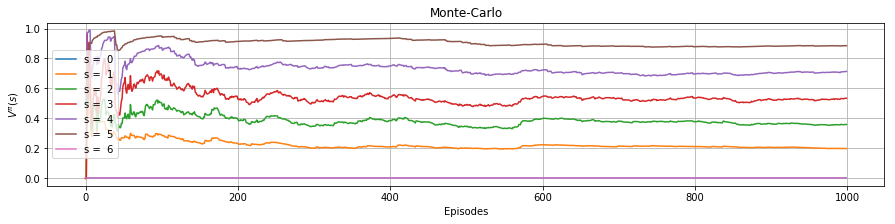

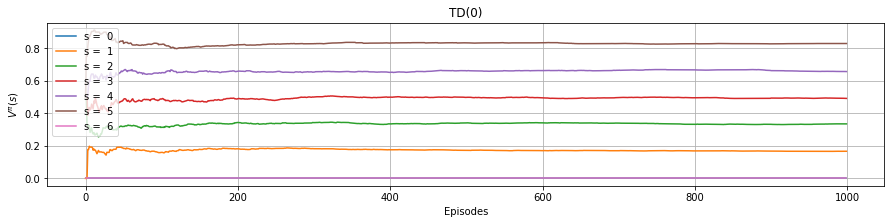

In [16]:
utils.plot_value_estimates(utils.timeseries(mc_estimates), 'Monte-Carlo')
utils.plot_value_estimates(utils.timeseries(td_estimates), 'TD(0)')

### Analyzing quality of prediction

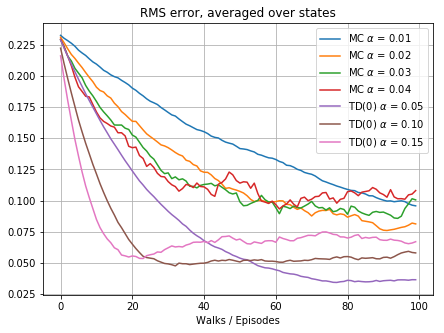

In [17]:
def quality_eval(V_optimal, predictor, learning_rates, episodes, name=None):
    avg_error = {}
    for alpha in learning_rates:
        errors = []
        for i in range(100):
            V = TabularStateValue(env.observation_space.n, initial_value=0.5)
            V[0] = V[-1] = 0.0
            learning_rate = lambda i: alpha
            p = predictor(V, policy, learning_rate, discount_factor)
            p.run(env, episodes)
            estimates = p.logger.stats['estimates']
            rms_error = utils.rms_series([e[1:-1] for e in estimates], V_optimal)
            errors.append(rms_error)
        avg_error['{} $\\alpha$ = {:.2f}'.format(name, alpha)] = np.mean(errors, axis=0)
    return avg_error

episodes = 100

alpha = [0.01, 0.02, 0.03, 0.04]
mc_avg_error = quality_eval(V_optimal, MonteCarloPredictor, alpha, episodes, name='MC')

alpha = [0.05, 0.10, 0.15]
td_avg_error = quality_eval(V_optimal, TDPredictor, alpha, episodes, name='TD(0)')

utils.plot_rms_errors([mc_avg_error, td_avg_error])